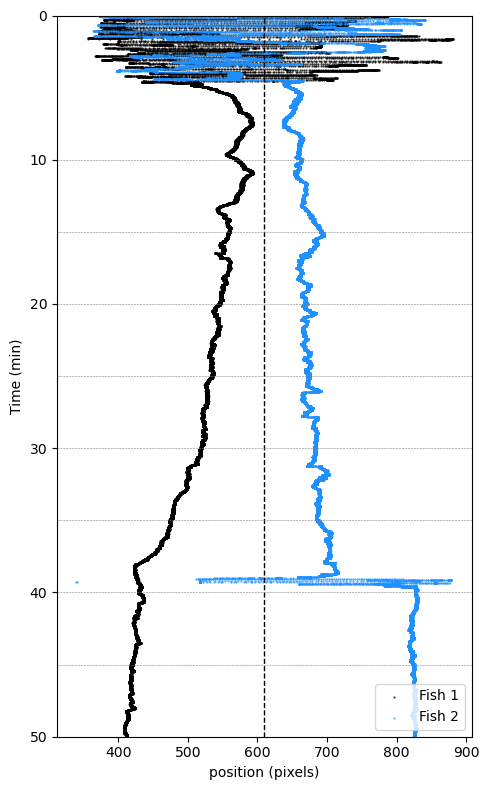

Saved: ../plots/two_fish_plot.png


In [ ]:

# 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 
csv_paths = [
    r"../src/Dji 20250915141201 0042 D Fish B9633 (2) Small file sizeDLC_Resnet50_3rd_attemptOct26shuffle2_snapshot_1000.csv",   # File 1
    r"../src/Dji 20250916121117 0045 D Fish B95f1 (5) Small file sizeDLC_Resnet50_3rd_attemptOct26shuffle2_snapshot_1000.csv"    # File 2
]
colors = ["black", "dodgerblue"]      # colours for each fish
labels = ["Fish 1", "Fish 2"]          # legend labels
bodypart = "Head"
lik_cutoff = 0.9
total_minutes = 50                     # duration of recording in minutes
save_path = r"../plots/two_fish_plot.png"
# 


def process_csv(path, bodypart, lik_cutoff, total_minutes):
    """Load DLC CSV and return cleaned x and time vectors."""
    df = pd.read_csv(path, header=[0,1,2])
    scorer = df.columns[1][0]

    x = df[(scorer, bodypart, "x")].astype(float).values
    p = df[(scorer, bodypart, "likelihood")].astype(float).values

    # Clean likelihood
    x_clean = x.copy()
    x_clean[p < lik_cutoff] = np.nan
    x_clean = pd.Series(x_clean).interpolate(limit_direction="both").values

    n_frames = len(x_clean)

    # Estimate fps
    total_seconds = total_minutes * 60
    fps_est = n_frames / total_seconds

    # Time axis in minutes
    t_sec = np.arange(n_frames) / fps_est
    t_min = t_sec / 60.0

    return x_clean, t_min


def main():
    processed = []

    # Load and process each file
    for path in csv_paths:
        x_clean, t_min = process_csv(path, bodypart, lik_cutoff, total_minutes)
        processed.append((x_clean, t_min))

    # Determine global midline (shared between fish)
    all_x = np.concatenate([p[0] for p in processed])
    mid_x = np.nanmean([np.nanmin(all_x), np.nanmax(all_x)])

    # 
    fig, ax = plt.subplots(figsize=(5, 8))

    for (x_clean, t_min), col, lab in zip(processed, colors, labels):
        ax.scatter(x_clean, t_min, s=0.4, color=col, alpha=0.7, label=lab)

    # Midline
    ax.axvline(mid_x, linestyle="--", linewidth=1, color="black")

    # Horizontal phase boundaries
    phase_bounds_min = [0, 10, 15, 20, 25, 30, 35, 40, 45, 50]
    for b in phase_bounds_min:
        ax.axhline(b, linestyle="--", linewidth=0.4, color="gray")

    ax.set_xlabel("position (pixels)")
    ax.set_ylabel("Time (min)")
    ax.set_title("")

    # Vertical orientation (0 min on top)
    ax.set_ylim(total_minutes, 0)

    # Legend
    ax.legend(loc="lower right")

    plt.tight_layout()
    plt.savefig(save_path, dpi=200)
    plt.show()

    print("Saved:", save_path)

if __name__ == "__main__":
    main()


C:\Users\htbib\AppData\Local\Temp\ipykernel_18876\12777830.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


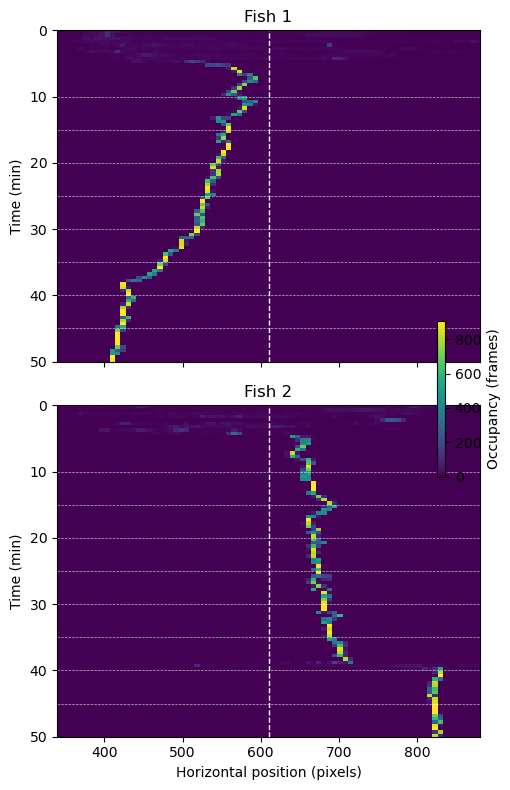

Saved heatmap figure to: ../plots/two_fish_heatmaps.png


In [ ]:
#!/usr/bin/env python3
# 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 
csv_paths = [
    r"../src/Dji 20250915141201 0042 D Fish B9633 (2) Small file sizeDLC_Resnet50_3rd_attemptOct26shuffle2_snapshot_1000.csv",   # File 1
    r"../src/Dji 20250916121117 0045 D Fish B95f1 (5) Small file sizeDLC_Resnet50_3rd_attemptOct26shuffle2_snapshot_1000.csv"    # File 2
]
labels        = ["Fish 1", "Fish 2"]          # titles per fish
bodypart      = "Head"
lik_cutoff    = 0.9
total_minutes = 50                            # duration of recording in minutes
save_path     = r"../plots/two_fish_heatmaps.png"

# Heatmap resolution (you can tweak these)
n_xbins = 80      # horizontal bins
n_tbins = 100     # time bins (0–50 min)
# 


def process_csv(path, bodypart, lik_cutoff, total_minutes):
    """Load DLC CSV and return cleaned x and time vectors."""
    df = pd.read_csv(path, header=[0, 1, 2])
    scorer = df.columns[1][0]

    x = df[(scorer, bodypart, "x")].astype(float).values
    p = df[(scorer, bodypart, "likelihood")].astype(float).values

    # Clean likelihood
    x_clean = x.copy()
    x_clean[p < lik_cutoff] = np.nan
    x_clean = pd.Series(x_clean).interpolate(limit_direction="both").values

    n_frames = len(x_clean)

    # Estimate fps from known total duration
    total_seconds = total_minutes * 60
    fps_est = n_frames / total_seconds

    # Time axis in minutes
    t_sec = np.arange(n_frames) / fps_est
    t_min = t_sec / 60.0

    return x_clean, t_min


def main():
    processed = []

    # Load and process each file
    for path in csv_paths:
        x_clean, t_min = process_csv(path, bodypart, lik_cutoff, total_minutes)
        processed.append((x_clean, t_min))

    # Determine global x-range (shared bins across all fish)
    all_x = np.concatenate([p[0] for p in processed])
    x_min = np.nanmin(all_x)
    x_max = np.nanmax(all_x)

    # Global midline
    mid_x = 0.5 * (x_min + x_max)

    # Define common bin edges
    x_edges = np.linspace(x_min, x_max, n_xbins + 1)
    t_edges = np.linspace(0, total_minutes, n_tbins + 1)

    n_fish = len(processed)

    fig, axes = plt.subplots(
        n_fish, 1,
        figsize=(5, 4 * n_fish),
        sharex=True,
        sharey=True
    )

    # If only one fish, axes is not a list
    if n_fish == 1:
        axes = [axes]

    for (x_clean, t_min), ax, label in zip(processed, axes, labels):
        # 2D histogram: time vs position
        # Note: order is (time, x) so that x is horizontal axis, time vertical
        H, t_edges_used, x_edges_used = np.histogram2d(
            t_min, x_clean,
            bins=[t_edges, x_edges]
        )

        # Plot heatmap
        im = ax.imshow(
            H,
            origin="upper",      # 0 min at top
            aspect="auto",
            extent=[x_edges[0], x_edges[-1], t_edges[-1], t_edges[0]]
        )

        # Midline
        ax.axvline(mid_x, linestyle="--", linewidth=1, color="white")

        # Horizontal phase boundaries (0–10, then every 5 min)
        phase_bounds_min = [0, 10, 15, 20, 25, 30, 35, 40, 45, 50]
        for b in phase_bounds_min:
            ax.axhline(b, linestyle="--", linewidth=0.5, color="white", alpha=0.7)

        ax.set_ylabel("Time (min)")
        ax.set_title(label)

    axes[-1].set_xlabel("Horizontal position (pixels)")

    # Colourbar
    cbar = fig.colorbar(im, ax=axes, orientation="vertical", fraction=0.02, pad=0.02)
    cbar.set_label("Occupancy (frames)")

    plt.tight_layout()
    plt.savefig(save_path, dpi=200)
    plt.show()

    print("Saved heatmap figure to:", save_path)


if __name__ == "__main__":
    main()
